In [1]:
# Import the usual stuff
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Sequence, Tuple

# Path to harmonic oscillator modules
import sys
import os
module_path=os.path.abspath('/Users/zentner/Work/PhysicsModels/schrodinger1d')
if module_path not in sys.path:
    sys.path.append(module_path)

import schrodinger_solver_1d as sch
import potentials_1d as pot
import wavefunctions as psi
import find_eigen_functions as eigen

In [2]:
# ---- my spatial and Fourier grid ----
# ---- the grid must respect the periodicity of the potential --

def make_periodic_grid(Ncells,Nppc,a=1.0) -> tuple[sch.Grid1D, float]:
    """
    make a periodic grid for periodic problems.
    """
    N = Ncells*Nppc # total number of points in the computational domain
    L = Ncells*a  # length of the computational domain.
    y_max = L/2.0
    return sch.make_grid(N,y_max), L

N_cells = 2**4 # number of unit cells
N_ppc = 2**8 # number of modeling points per unit cell
a = 1.0 # periodicity

grid_fft, L = make_periodic_grid(N_cells, N_ppc)

In [3]:
# ---- initial state ----
t0 = 0.0 # initial time
n0 = 1 # initial eigenstate, n=1 is ground state of particle in a box!
psi0 = psi.free_particle(grid_fft.y, n0, L) # the wavefunction, start in free particle state
e0 = psi.free_particle_energy(n0) # energy of the intial state.
print(rf'The energy of the initial state is {e0:.2e} in units of $\hbar^2/mL^2$')
print(' - ')
print(' ')

#----- cosine potential
v0 = -1.0
v_cos = pot.CosinePotential(V0=v0)

#----- check periodicity of potential
# periodic over the whole box should mean V(x+L)=V(x); on the grid it shows up as endpoint match
Vx=v_cos(grid_fft.y,0.0)
print("V[0], V[-1] =", Vx[0], Vx[-1], "difference:", abs(Vx[0]-Vx[-1]))

# periodic over one cell: compare shift by a
dy = grid_fft.dy
shift = int(round(2.0*a/dy))
print("a/dy =", a/dy, "shift =", shift)
print("max |V(x)-V(x+a)|:", np.max(np.abs(Vx - np.roll(Vx, shift))))


The energy of the initial state is 1.97e+01 in units of $\hbar^2/mL^2$
 - 
 
V[0], V[-1] = -1.0 -0.9999247018391445 difference: 7.529816085549701e-05
a/dy = 512.0 shift = 1024
max |V(x)-V(x+a)|: 3.2459329983770742e-15


In [4]:
# ---- time grid ----
tmax = 50.0/e0 # set the timestep according to the natural scale of evolution.
tau_grid = np.linspace(0.0,10.0,8001)

# ---- evolve using fft ----
psi_g, diag = eigen.imaginary_time_propagate_fft(psi0=psi0,
                            V_of_y_tau=v_cos,
                            tau_grid=tau_grid,
                            grid=grid_fft,
                            return_all=True)

# ---- check the drift of the normalization ---
print("Norm drift:", diag["norm"].min(), diag["norm"].max())
if ( np.abs(diag["norm"].max() - diag["norm"].min()) > 1.0e-4 ):
    print(" Unacceptably large norm drift.")
print(' ')

psi_ground = psi_g[-1]

Norm drift: 0.9999999999999996 1.0000000000000004
 


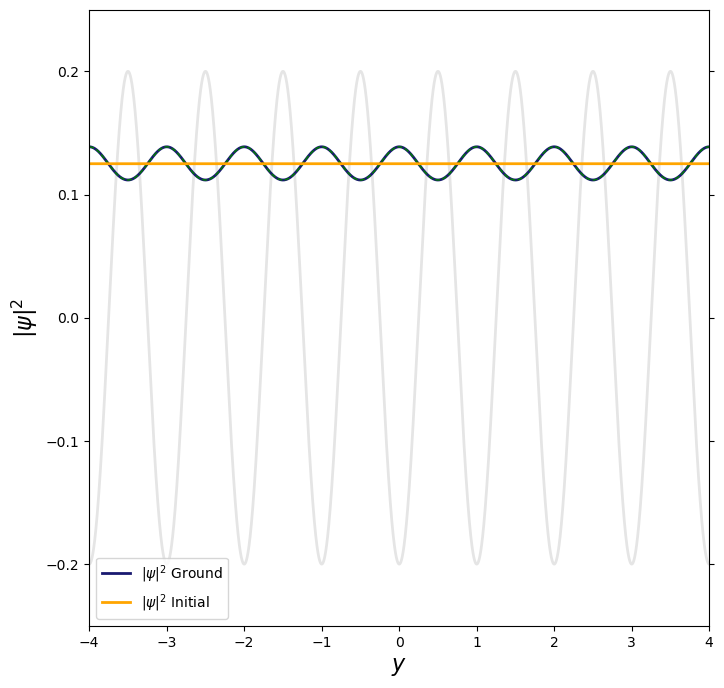

In [5]:
#Plot |psi|^2 #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_fft.y,diag["tau"][0])

plt.plot(grid_fft.y,v/5.0,linewidth=2.0,color='black',alpha=0.1)
plt.plot(grid_fft.y,np.abs(psi_g[-1])**2,linewidth=2.0,color='midnightblue',label=r'$\vert \psi \vert^2$ Ground')
plt.plot(grid_fft.y,np.abs(psi_g[-20])**2,linewidth=1.0,color='green',linestyle='dashed')
plt.plot(grid_fft.y,np.abs(psi_g[0])**2,linewidth=2.0,color='orange',label=r'$\vert \psi \vert^2$ Initial')

plt.xlabel(r"$y$",fontsize=16)
plt.ylabel(r"$\vert \psi \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(-4.0,4.0)
plt.ylim(-0.25,0.25)

plt.legend()
plt.show()

In [6]:
#---- check the converegence of <H> ----
Nt = psi_g.shape[0]
H = np.empty(Nt,dtype=float)
for j in range(Nt):
    vals = sch.expectation_H(psi=psi_g[j],
                             grid=grid_fft,
                             V_of_y_tau=v_cos,
                             tau=float(tau_grid[j])
                            )
    H[j] = vals["H"]

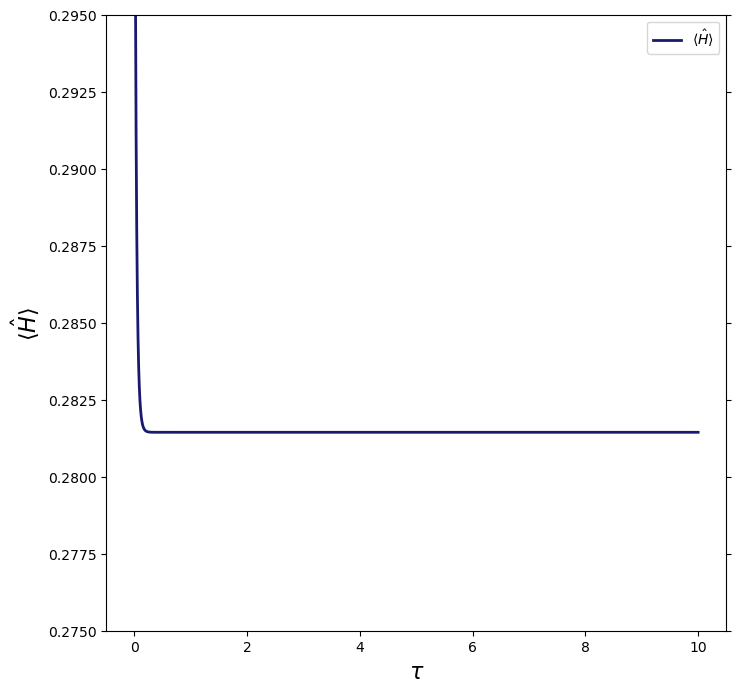

In [7]:
# Check <H> #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_fft.y,diag["tau"][0])

plt.plot(diag["tau"],H,linewidth=2.0,color='midnightblue',label=r'$\langle \hat{H} \rangle$')

plt.xlabel(r"$\tau$",fontsize=16)
plt.ylabel(r"$\langle \hat{H} \rangle$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

#plt.xlim(0.0,5.0)
plt.ylim(0.275,0.295)

plt.legend()
plt.show()

In [8]:
# -- we are going to check that the ground state which we found, does not evolve -- 
# -- so we will use a new grid, because it should be robust to this choice.
N_cells = 2**4 # number of unit cells
N_ppc = 2**8 # number of modeling points per unit cell
a = 1.0 # periodicity

grid_test, L_test = make_periodic_grid(N_cells, N_ppc)

In [9]:
#---- evolve the ground state and check that it does not evolve! --|

# ---- initial state ----
t0 = 0.0 # initial time
psi0 = psi_ground # the wavefunction, start in state n0
vals = sch.expectation_H(psi=psi0,
                             grid=grid_test,
                             V_of_y_tau=v_cos,
                             tau=float(t0)
                        )
e_ground = vals["H"] # energy of the intial state.
print(rf'The energy of the initial state is {e_ground:.2e} in units of $\hbar^2/mL^2$')


The energy of the initial state is 2.81e-01 in units of $\hbar^2/mL^2$


In [10]:
# ---- time grid ----
tmax = 50.0/e0 # set the timestep according to the natural scale of evolution.
tau_grid = np.linspace(0.0,10.0,8001)

# ---- evolve using fft ----
psi_t, diag = sch.yoshida_step_propagate(psi0=psi0,
                            V_of_y_tau=v_cos,
                            tau_grid=tau_grid,
                            grid=grid_test,
                            return_all=True)

# ---- check the drift of the normalization ---
print("Norm drift:", diag["norm"].min(), diag["norm"].max())
if ( np.abs(diag["norm"].max() - diag["norm"].min()) > 1.0e-4 ):
    print(" Unacceptably large norm drift.")
print(' ')

Norm drift: 1.0 1.0000000000014428
 


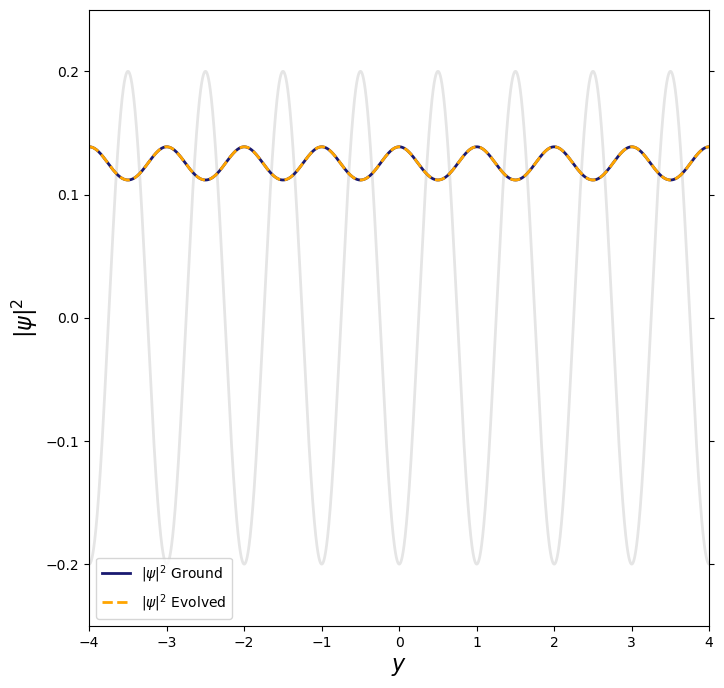

In [11]:
#Plot |psi|^2 #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_test.y,diag["tau"][0])

plt.plot(grid_fft.y,v/5.0,linewidth=2.0,color='black',alpha=0.1)
plt.plot(grid_fft.y,np.abs(psi_ground)**2,linewidth=2.0,color='midnightblue',label=r'$\vert \psi \vert^2$ Ground')
plt.plot(grid_test.y,np.abs(psi_t[-1])**2,linewidth=2.0,color='orange',linestyle='dashed',label=r'$\vert \psi \vert^2$ Evolved')

plt.xlabel(r"$y$",fontsize=16)
plt.ylabel(r"$\vert \psi \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(-4.0,4.0)
plt.ylim(-0.25,0.25)

plt.legend()
plt.show()

In [12]:
# --- lastly, let's try to find the first few excited states in addition ---
# --- it needs an energy function
def energy_fn(psi):
    return sch.expectation_H(psi=psi, grid=grid_test, V_of_y_tau=v_cos, bc="fft")["H"]

#--- give bloch quasi-momenta in first Brillouin Zone
m_values = eigen.make_m_list_first_bz(grid_test,a=1.0) # periodicity is set to 1.0
n_bands = 2

#--- guesses
def make_bloch_guess_from_free_particle(
    *,
    grid,
    m_list: Sequence[int],
    n_bands: int,
    noise_level: float = 0.05,
    seed: int = 0,
) -> Dict[Tuple[int, int], np.ndarray]:
    """
    Build psi_guesses dict for periodic Bloch-sector eigenfinder
    using your free_particle() function.

    Keys are (m, band).

    Parameters
    ----------
    grid : object with attributes y and dy
    m_list : list of Bloch sector indices
    n_bands : number of bands per sector
    noise_level : amplitude of complex noise added to guesses
    seed : RNG seed for reproducibility
    """

    rng = np.random.default_rng(seed)

    y = grid.y
    Ny = y.size
    L = Ny * grid.dy

    psi_guesses: Dict[Tuple[int, int], np.ndarray] = {}

    for m in m_list:
        # Free particle plane wave in this Bloch sector
        base = psi.free_particle(y, n=m, L=L)

        for band in range(n_bands):

            if band == 0:
                # lowest band guess: pure plane wave + small noise
                noise = noise_level * (
                    rng.normal(size=Ny) + 1j * rng.normal(size=Ny)
                )
                psi0 = base + noise

            else:
                # higher bands: bias toward slightly higher Fourier content
                # n = m + band shifts momentum slightly
                base_shifted = psi.free_particle(y, n=m + band, L=L)
                noise = noise_level * (
                    rng.normal(size=Ny) + 1j * rng.normal(size=Ny)
                )
                psi0 = base_shifted + noise

            psi_guesses[(m, band)] = psi0.astype(np.complex128)

    return psi_guesses

#--- build guesses
psi_guesses = make_bloch_guess_from_free_particle(grid=grid_test,
                                                  m_list=m_values,
                                                  n_bands=n_bands)
    

#--- find the first few states
res = eigen.find_bloch_states(n_bands = n_bands,
                              m_list = m_values,
                              grid = grid_test,
                              V_of_y = v_cos,
                              energy_fn = energy_fn,
                              a=1.0)

psis = res["psis"]
energies = res["energies"]
k_vals = res["k_vals"]

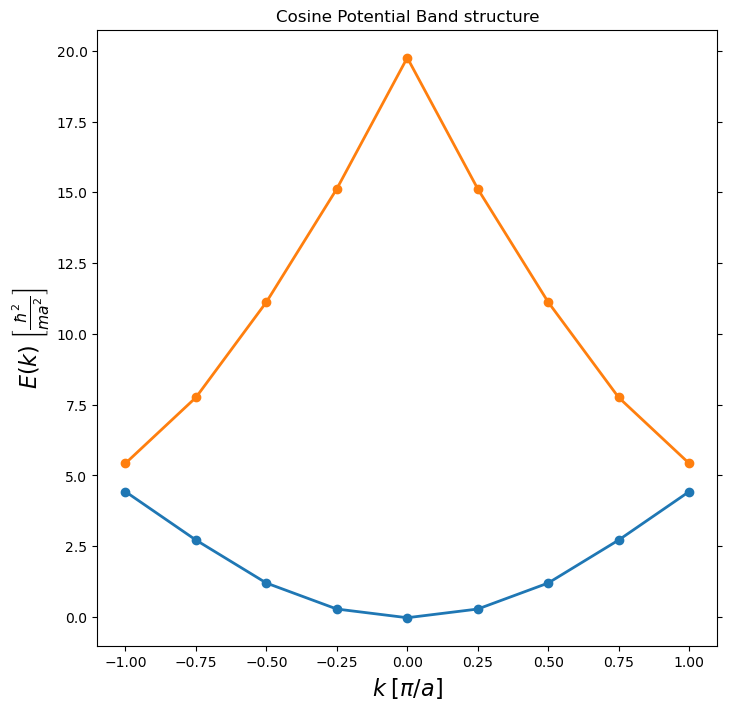

In [13]:
#--- let's plot a band diagram
#
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)
#

# sort by k so the lines connect in order
k_bz = eigen.wrap_to_first_bz(k_vals,a=1.0) # put quasimomenta in first Brillouin Zone

idx = np.argsort(k_bz)
k_sorted = k_bz[idx]/(np.pi/a)
E_sorted = energies[idx, :]

k_sorted = np.concatenate([k_sorted,[1.0]])
E_sorted = np.vstack([E_sorted, E_sorted[0, :]])

for band in range(E_sorted.shape[1]):
    plt.plot(k_sorted, E_sorted[:, band], marker="o", linewidth=2.0)
    
plt.xlabel(r"$k\; \left[ \pi/a \right]$",fontsize=16)
plt.ylabel(r"$E(k) \; \left[ \frac{\hbar^2}{m a^2} \right]$",fontsize=16)

plt.title("Cosine Potential Band structure")

plt.show()

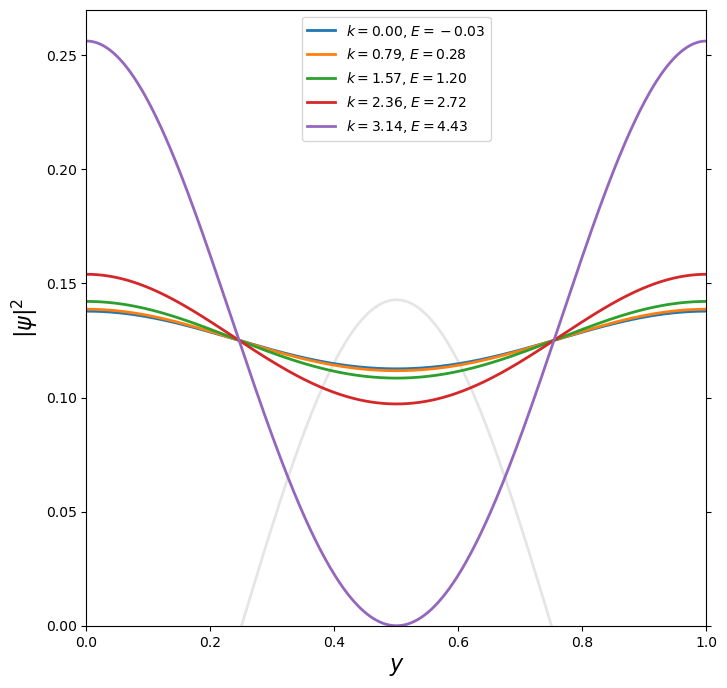

In [14]:
#Plot |psi|^2 #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_test.y,diag["tau"][0])

plt.plot(grid_test.y,v/7.0,linewidth=2.0,color='black',alpha=0.1)

for ik in range(5):
    plt.plot(grid_test.y, np.abs(psis[ik][0])**2, linewidth=2.0, label=rf'$k = {np.abs(k_vals[ik]):.2f}$, $E = {energies[ik,0]:.2f}$')

plt.xlabel(r"$y$",fontsize=16)
plt.ylabel(r"$\vert \psi \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(0.0,1.0)
plt.ylim(0.0,0.27)

plt.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


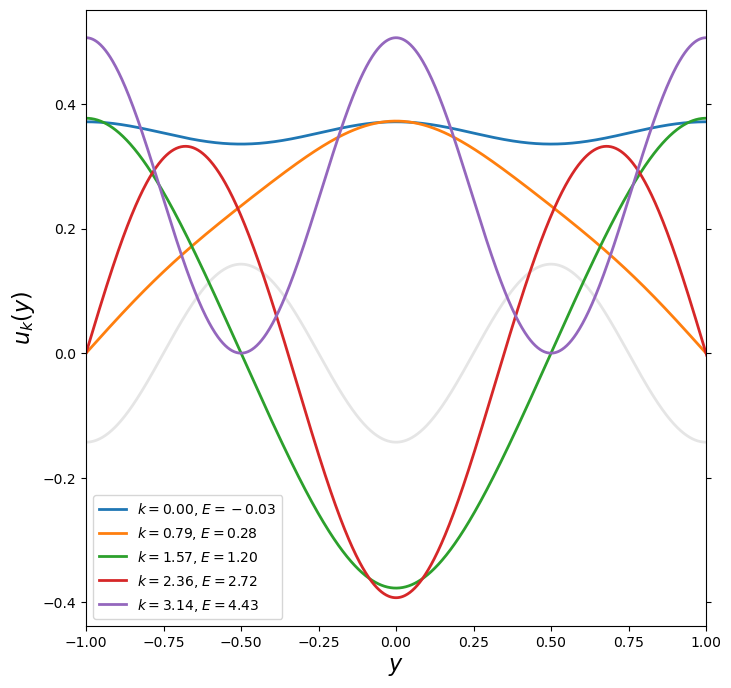

In [15]:
#Plot u_k(y) #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_test.y,diag["tau"][0])

plt.plot(grid_test.y,v/7.0,linewidth=2.0,color='black',alpha=0.1)

for ik in range(5):
    u = np.exp(-1.0j*k_vals[ik]*grid_test.y)*psis[ik][0]
    j0 = np.argmax(np.abs(u))
    u *= np.exp(-1.0j*np.angle(u[j0]))
    plt.plot(grid_test.y, u, linewidth=2.0, label=rf'$k = {np.abs(k_bz[ik]):.2f}$, $E = {energies[ik,0]:.2f}$')

plt.xlabel(r"$y$",fontsize=16)
plt.ylabel(r"$u_{k}(y)$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(-1.0,1.0)
#plt.ylim(0.0,0.27)

plt.legend()
plt.show()

In [16]:
dir(eigen)

['Array',
 'BlochProjector',
 'Callable',
 'Dict',
 'List',
 'Optional',
 'Sequence',
 'Tuple',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'find_bloch_states',
 'find_states_imag_time',
 'gram_schmidt_inplace',
 'gs_inner_product',
 'imag_time_step_inplace_dst',
 'imag_time_step_inplace_fft',
 'imaginary_time_propagate_fft',
 'make_m_list_first_bz',
 'normalize_inplace',
 'np',
 'wrap_to_first_bz']